In [90]:
import os
from pathlib import Path
from typing import Annotated

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import tifffile
from einops import rearrange, repeat

In [65]:
plt.rcParams['svg.fonttype'] = 'none'

In [134]:
output_dir = Path('../data/cell_type_grid_analysis_for_julia')
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
meta = pd.read_csv(
    '/diskmnt/Projects/SenNet_analysis/Main.analysis/bm/JW_workspace/IRD_xenium_analysis_2/annotations/annot_xenium_paths.txt',
    sep='\t',
    index_col=0
)
meta

,UPN,UPN_Sample,annotation_csv,Output.file.path
Sample,,,,
IRD_S18-30740A1U3,WU108,WU108_IRD_S18-30740A1U3,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20240821__204457_...
S11-3564A1U1,14926,14926_S11-3564A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250116__195216_...
S13-35096A1U1,10483,10483_S13-35096A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250113__211232_...
S13-47674A1U1,21167,21167_S13-47674A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250113__211232_...
S14-11561A1U1,20799,20799_S14-11561A1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20241221__004049_...
...,...,...,...,...
SP126U1-A1-S1Fp1U1,WU107,WU107_SP126U1-A1-S1Fp1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250530__173331_...
SP127U1-A1-S1Fp1U1,WU007,WU007_SP127U1-A1-S1Fp1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250620__162328_...
SP129U1-A1-S1Fp1U1,WU030,WU030_SP129U1-A1-S1Fp1U1,/diskmnt/Projects/SenNet_analysis/Main.analysi...,/diskmnt/primary/Xenium/data/20250620__162328_...


In [127]:
def generate_fractions(
        cell_df: Annotated[pd.DataFrame, 'Data table read in from cells.parquet in the spaceranger outputs directory.'],
        annotation_df: Annotated[pd.DataFrame, 'Data table where index is the cell barcode, (matches cell_df), and the column is the cell group.'],
        grid_size: Annotated[int, 'Size of binned grids in microns.'] = 200
    ) -> pd.DataFrame:
    """
    Returns dataframe that contains fractions for each grid square of the given size.
    """
    df = pd.merge(annotation_df, cell_df, how='inner', left_index=True, right_index=True)
    
    df['x_grid'] = (df['x_centroid'] // grid_size).astype(int)
    df['y_grid'] = (df['y_centroid'] // grid_size).astype(int)
    df['grid'] = [f'{x}_{y}' for x, y in df[['x_grid', 'y_grid']].values]
    
    df['dummy'] = 1
    grouped = df[['grid', 'group', 'dummy']].groupby(['group', 'grid']).count()
    grouped = grouped.reset_index()
    
    value_df = pd.pivot_table(grouped, values='dummy', index='grid', columns='group')
    value_df[pd.isnull(value_df)] = 0
    value_df = value_df.astype(int)
    
    sums = value_df.values.sum(1, keepdims=True)
    value_df /= sums
    value_df['total_count'] = sums
    
    return value_df

def generate_array(
        value_df: Annotated[pd.DataFrame, 'Cell fraction dataframe generated from generate_fractions.'],
        group: Annotated[str, 'Column of value_df for which to return data.']
    ) -> np.ndarray:
    """
    Returns 2D array of values reprsenting the given group arranged by their grid square.
    """
    coords = np.asarray([[int(val) for val in x.split('_')] for x in value_df.index.to_list()])

    # switch to y, x
    coords = coords[:, [1, 0]]
    
    blank = np.zeros(coords.max(0) + 1)
    blank[coords[:, 0], coords[:, 1]] = value_df[group]
    
    return blank

def plot_value_df(
        value_df: Annotated[pd.DataFrame, 'Cell fraction dataframe generated from generate_fractions.'],
        thresh: Annotated[int | float, 'Grids below this threshold will be grayed out.'] = 30
    ):
    """
    Display the value dataframe generated by generate_array.
    """
    count_arr = generate_array(value_df, 'total_count')
    mask = count_arr < thresh
    alphas = np.ones_like(mask, dtype=np.float32)
    alphas[~mask] = 0
    gray = repeat(alphas, 'h w -> h w 3')
    gray *= .8
    gray *= 255
    gray = gray.astype(np.uint8)
    gray = np.concat((gray, rearrange((alphas * 255).astype(np.uint8), 'h w -> h w 1')), -1)
    
    fig, axs = plt.subplots(nrows=value_df.shape[1], figsize=(5, 15))
    for i, ax in enumerate(axs):
        group = value_df.columns[i]
        arr = generate_array(value_df, group)

        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_xticks([])

        ax.set_ylabel(group, rotation=90)
        im = ax.imshow(arr)
        plt.colorbar(im)

        if i != value_df.shape[1] - 1:
            ax.imshow(gray, alpha=1)

running a test case here

In [57]:
spaceranger_dir = Path(meta['Output.file.path'].iloc[0])
assert spaceranger_dir.is_dir(), f'{spaceranger_dir} is not a directory.'

cell_df = pd.read_parquet(spaceranger_dir / 'cells.parquet').set_index('cell_id')
cell_df

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area
cell_id,,,,,,,,,,
aaaacbaj-1,162.707626,1595.411865,0,0,0,0,0,0,107.878285,NaN
aaaamgce-1,173.980057,1963.590088,0,0,0,0,0,0,90.628597,NaN
aaabbkmd-1,155.252213,1959.910645,0,0,0,0,0,0,36.170158,NaN
aaabpfoi-1,308.305176,975.515076,1,0,0,0,0,1,57.890315,NaN
aaachomd-1,177.132095,1591.368530,0,0,0,0,0,0,46.736720,NaN
...,...,...,...,...,...,...,...,...,...,...
oiiapcge-1,3957.719727,1314.297852,4,0,0,0,0,4,11.740625,11.740625
oiibijpn-1,3959.610107,1307.626831,5,0,0,0,0,5,56.761408,14.946719
oiicmknh-1,3961.602783,1300.265259,13,0,0,0,0,13,74.146565,29.035470


In [58]:
annotation_df = pd.read_csv(meta['annotation_csv'].iloc[0], index_col=0)
annotation_df

,group
cell_id,
aaaefkpp-1,Erythroid
aaaekejm-1,Progenitor
aaaekekb-1,T/NK
aaaeonma-1,Erythroid
aaaflkno-1,Erythroid
...,...
oihnnjdl-1,Myeloid
oihohdaj-1,T/NK
oihpoooc-1,Myeloid


In [59]:
value_df = generate_fractions(cell_df, annotation_df, grid_size=200)
value_df

group,B,Erythroid,MKC,Myeloid,PC,Progenitor,Stromal,T/NK,pDC,total_count
grid,,,,,,,,,,
10_0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
10_10,0.018182,0.254545,0.0,0.454545,0.054545,0.163636,0.0,0.054545,0.000000,55
10_11,0.009091,0.381818,0.0,0.245455,0.181818,0.136364,0.0,0.027273,0.018182,110
10_12,0.115385,0.307692,0.0,0.384615,0.038462,0.076923,0.0,0.076923,0.000000,26
10_3,0.000000,0.313725,0.0,0.254902,0.117647,0.254902,0.0,0.058824,0.000000,51
...,...,...,...,...,...,...,...,...,...,...
9_4,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,1
9_5,0.000000,0.250000,0.0,0.750000,0.000000,0.000000,0.0,0.000000,0.000000,4
9_7,0.000000,0.200000,0.0,0.300000,0.300000,0.200000,0.0,0.000000,0.000000,10


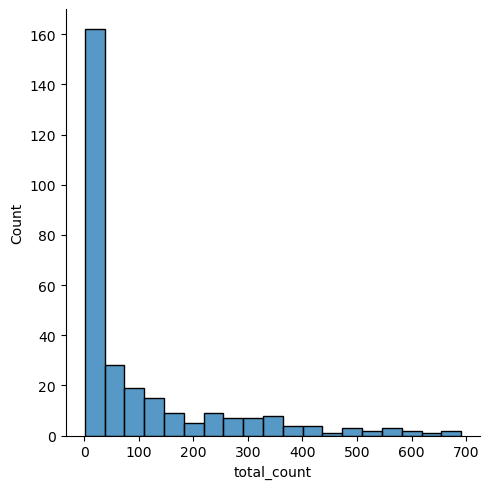

In [78]:
sns.displot(value_df['total_count'])

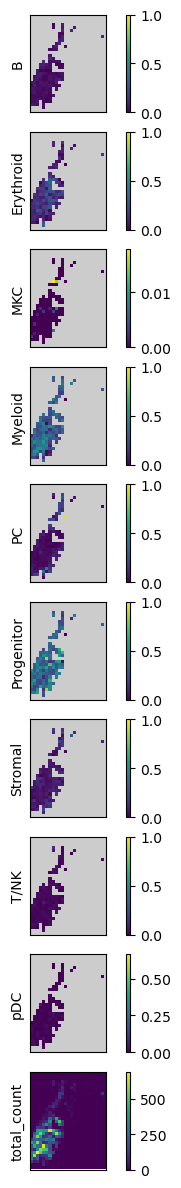

In [129]:
plot_value_df(value_df, thresh=30)

In [136]:
for sid, row in meta.iterrows():
    print(sid)
    spaceranger_dir = Path(row['Output.file.path'])
    assert spaceranger_dir.is_dir(), f'{spaceranger_dir} is not a directory.'
    cell_df = pd.read_parquet(spaceranger_dir / 'cells.parquet').set_index('cell_id')
    
    annotation_df = pd.read_csv(row['annotation_csv'], index_col=0)
    
    value_df = generate_fractions(cell_df, annotation_df, grid_size=200)
    value_df.to_csv(output_dir / f'{sid}_fractions.txt', sep='\t')
    
    plot_value_df(value_df, thresh=30)
    plt.savefig(output_dir / f'{sid}_plots.svg')
    plt.clf()
    plt.close()

IRD_S18-30740A1U3
S11-3564A1U1
S13-35096A1U1
S13-47674A1U1
S14-11561A1U1
S14-14053A1U1
S14-14053A1U2
S14-18864-A1U1
S14-22950-A1U1
S14-9876A1U1
S15-15758-A1U1
S16-26183A1U1
S16-30080A1U1
S17-24784A1U1
S17-24784A1U2
S17-32736-A1U1
S17-34578-A1U1
S17-5570A1U1
S18-36373A1U1
S18-461-A1U1
S18-6148A1U1
S19-25371-A1U1
S20-2375-A1U1
S21-1209-A1U1
S21-19998-A1U1Q1
S21-19998-A1U1Q2
S22-3386-A1U1
S24-19138A1U1
SN113R1-Ma1Fd2-2U2
SN126F1-Ma1Fd2-4U3
SN131R1-Ma1Fd2-12U1
SN151R1-Ma1Fd2-2U1
SN154R1-Ma1Fd2-1U1
SN160R1-Ma1Fd2-15U1
SN161R1-Ma1Fd2-3U1
SN169R1-Ma1Fd2-1U1
SN174R1-14U1
SN198R1-Ma1Fd2-1U2
SN200R1-Ma1Fd2-1U2
SN203R1-Ma1Fd2-2U2
SN207R1-Ma1Fd2-1U2
SN209R1-Ma1Fd2-2U2
SN215R1-Ma1Fd2P-1U1
SN218R1-Ma1Fd2-1U1
SN219R1-Ma1Fd2-1U1
SN221R1-Ma1Fd2P-1U1
SN222R1-Ma1Fd2-1U1
SN222R1-Ma1Fd2P-1U1
SN224R1-Ma1Fd2-1U1
SN225R1-Ma1Fd2-1U1
SN227R1-Ma1Fd2-2U1
SN228R1-Ma1Fd2-1U1
SP110U1-A1-S1Fp1U1
SP112U1-A1-S1Fp1U1
SP113U1-A1-S1Fp1U1
SP114U1-A1-S1Fp1U1
SP115U1-A1-S1Fp1U1
SP117U1-A1-S1Fp1U1
SP118U1-A1-S1Fp1U1Q1
SP118U1

In [137]:
fraction_fps = [output_dir / x for x in os.listdir(output_dir) if 'fractions.txt' in x]
data = []
for path in fraction_fps:
    path = path.expanduser().absolute()
    sid = str(path.name.replace('_fractions.txt', ''))
    data.append([sid, str(path), str(path).replace('_fractions.txt', '_plots.svg')])
output_df = pd.DataFrame(data, columns=['sample', 'fractions_filepath', 'gene_plots_filepath'])
output_df
    

,sample,fractions_filepath,gene_plots_filepath
0,SP110U1-A1-S1Fp1U1,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
1,S17-34578-A1U1,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
2,SN200R1-Ma1Fd2-1U2,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
3,S21-19998-A1U1Q2,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
4,S14-14053A1U2,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
...,...,...,...
64,S20-2375-A1U1,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
65,SN221R1-Ma1Fd2P-1U1,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
66,SP115U1-A1-S1Fp1U1,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...
67,SN222R1-Ma1Fd2-1U1,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...,/diskmnt/Users2/estorrs/ding-lab-spatial/noteb...


In [138]:
output_df.to_csv(output_dir / 'outputs_table.txt', sep='\t', index=None)